In [1]:
# pip install xgboost
# pip install hyperopt
#https://hyperopt.github.io/hyperopt/?source=post_page
# pip install category_encoders
# pip install scikit-optimize
# pip install dtreeviz


**Install Libraries**

In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb


import shap

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting


import dtreeviz
import graphviz



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder



# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler




**Load dataset (football_cleaned_supervised.csv)**

In [3]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [4]:
df_football= load_dataset('cleaned_files/football_clean_supervised.csv')

In [5]:
df_football.head(3)

Unnamed: 0           NAME  GRADE       AGE  SKILL STARCOLL  NUMOFF  POS  \
0           0   Arch Manning    2.0  18.28281  99.53    Texas    18.0  1.0   
1           1   Anthony Hill    2.0  18.00000  97.87    Texas    25.0  8.0   
2           2  CJ Baxter Jr.    2.0  18.00000  97.26    Texas    25.0  9.0   

   HEIGHT_IN  WEIGHT_LBS  ...  TIK_LONG  TOT_FOL     SPORT  RECRUIT_YEAR  \
0       75.5       220.0  ...    8900.0  73900.0  football        2023.0   
1       73.5       225.0  ...       0.0  13100.0  football        2023.0   
2       73.0       216.0  ...    1700.0  10900.0  football        2023.0   

   EXP_MONTHS  EXP_YEARS institution_name_short  ClassificationCode  \
0         2.0   0.189041                  Texas                 1.0   
1         2.0   0.189041                  Texas                 1.0   
2         2.0   0.189041                  Texas                 1.0   

       REV_MEN     EXP_MEN  
0  161532860.0  50633156.0  
1  161532860.0  50633156.0  
2  161532860.0  50633156.0  

[3 rows x 24 columns]

In [6]:
#save athlete names for later indexing
athlete_names = df_football['NAME']
# athlete_names

#remove Unnamed:0 and Sport column- not necessary 
def drop_col(df):
    df=df.drop(columns=['Unnamed: 0', 'NAME', 'STARCOLL', 'institution_name_short','SPORT'])
    return df

In [7]:
df_football = drop_col(df_football)



In [8]:
# # df_football.isna().sum()
df_football.columns
# df_football.info()

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

**Extract target and features. Perform Train-Test Split**

In [9]:

# Extract target and features
Target = 'NILVAL_LONG_USD'
Predictors = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN']

X = df_football.drop('NILVAL_LONG_USD', axis=1).values
y =  df_football[['NILVAL_LONG_USD']].values
# X.head(3)

In [10]:
#split the data
#Shuffle data given concern that dataset has athletes ordered by SKILL (but also look at skew later based on model performance)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)
print(X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1010, 18) (1010, 1)
(253, 18) (253, 1)


**XGBoostRegressor Base Model Decision Trees as Base Learners- using all features- using scikit learn**

In [11]:
#using default parameters, boosting rounds = 5  objective =reg:squarederror  XGBoost default is gbtree
xg_reg2 = XGBRegressor(n_estimators=5, random_state= 42)
xg_reg2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=5, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=42, reg_alpha=0, ...)

RMSE: 181733.650412
Train R2 Value: 0.7812387487093029
Accuracy Test 20.141702452059903


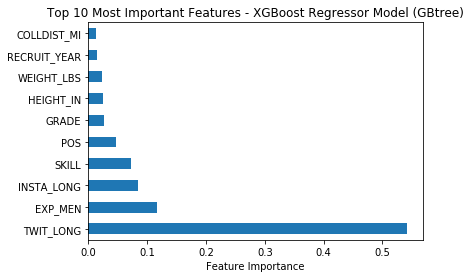

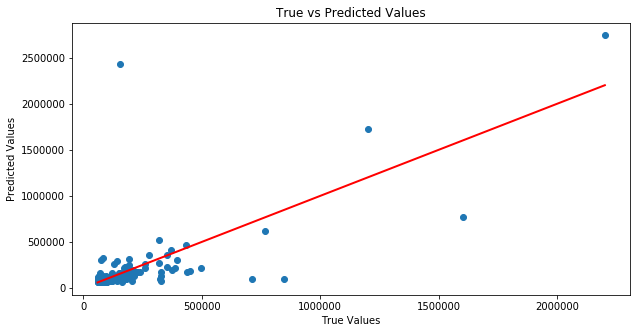

In [12]:
# Predict the labels of the test set: preds
preds = xg_reg2.predict(X_test)

# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

 
#Measuring Goodness of fit in Training data
from sklearn import metrics
print('Train R2 Value:',metrics.r2_score(y_train, xg_reg2.predict(X_train)))
 
#Measuring accuracy on Testing Data
print('Accuracy Test',100- (np.mean(np.abs((y_test - preds) / y_test)) * 100))



#Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(xg_reg2.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel ("Feature Importance")
plt.title("Top 10 Most Important Features - XGBoost Regressor Model (GBtree)")
 
#Printing some sample values of prediction
TestingDataResults=pd.DataFrame(data=X_test, columns=Predictors)
TestingDataResults[Target]=y_test
TestingDataResults[('Predicted'+Target)]=preds
TestingDataResults.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()


In [13]:
# metrics.classification_report(y_test, pred)

In [14]:
# https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_xgboost_visualisations.ipynb

#initialize dtreevizmodel (adaptor)

viz_rmodel = dtreeviz.model(model=xg_reg2, tree_index=1, 
                            X_train=df_football[Predictors],
                            y_train=df_football[Target], 
                            feature_names=Predictors, 
                            target_name=Target)

In [15]:
#Tree structure visualizations

# viz_rmodel.view()
viz_rmodel.view(orientation="LR")

C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Py

In [16]:
#Prediction path explanations
x = df_football[Predictors].iloc[10]
x
viz_rmodel.view(x=x)

C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Py

C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars


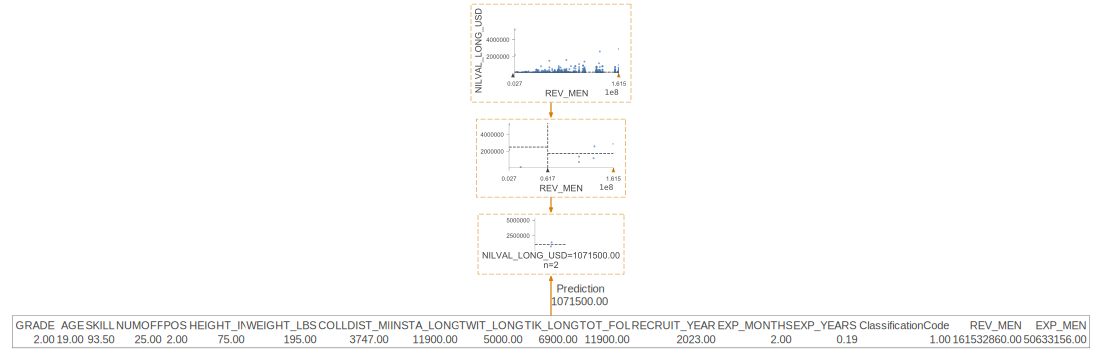

In [17]:
viz_rmodel.view(show_just_path=True, x = x)

In [18]:
print(viz_rmodel.explain_prediction_path(x))

61652272.0 <= REV_MEN 



In [19]:
# viz_rmodel.plot_importance(x, figsize=(3.5,2))

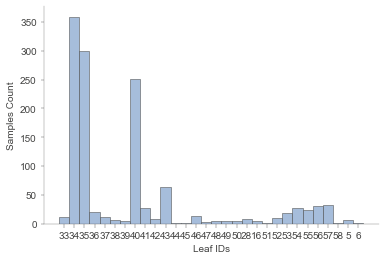

In [20]:
#leaf ratios
viz_rmodel.leaf_sizes()

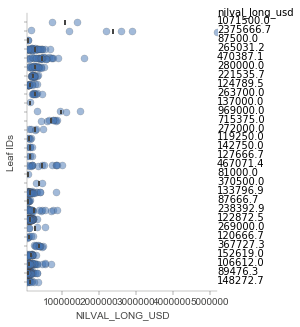

In [21]:
viz_rmodel.rtree_leaf_distributions()

In [22]:
viz_rmodel.node_stats(node_id=4)

GRADE         AGE       SKILL      NUMOFF         POS   HEIGHT_IN  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean     2.404762   18.476069   97.503750   23.303571    4.720238   74.550595   
std      2.024515    1.359121    0.928975    4.175433    2.976808    2.225761   
min      0.000000   16.000000   96.110000    1.000000    1.000000   68.500000   
25%      0.000000   17.000000   96.705000   24.000000    2.000000   73.000000   
50%      2.000000   19.000000   97.335000   25.000000    4.000000   75.000000   
75%      4.000000   20.000000   98.290000   25.000000    7.000000   76.500000   
max      6.000000   21.000000   99.590000   25.000000   15.000000   79.000000   

       WEIGHT_LBS  COLLDIST_MI    INSTA_LONG     TWIT_LONG      TIK_LONG  \
count  168.000000   168.000000  1.680000e+02    168.000000  1.680000e+02   
mean   227.010714   410.196429  3.000665e+04   9029.761905  2.097689e+04   
std     47.841832   445.936829  1.646255e+05   6752.906312  1.633321e+05   
min    155.000000     0.000000  1.600000e+03   1500.000000  0.000000e+00   
25%    185.750000   110.250000  5.594500e+03   4400.000000  0.000000e+00   
50%    215.000000   234.500000  9.150000e+03   7000.000000  5.930000e+02   
75%    261.500000   524.250000  1.772500e+04  12625.000000  4.825000e+03   
max    350.000000  2020.000000  2.122000e+06  52000.000000  2.100000e+06   

            TOT_FOL  RECRUIT_YEAR  EXP_MONTHS   EXP_YEARS  ClassificationCode  \
count  1.680000e+02    168.000000  168.000000  168.000000               168.0   
mean   3.000665e+04   2022.732143    8.880952    0.756327                 1.0   
std    1.646255e+05      1.201163    9.916302    0.831920                 0.0   
min    1.600000e+03   2021.000000    0.000000    0.000000                 1.0   
25%    5.594500e+03   2022.000000    0.000000    0.000000                 1.0   
50%    9.150000e+03   2023.000000    2.000000    0.189041                 1.0   
75%    1.772500e+04   2024.000000   14.000000    1.189041                 1.0   
max    2.122000e+06   2025.000000   26.000000    2.189041                 1.0   

            REV_MEN       EXP_MEN  
count  1.680000e+02  1.680000e+02  
mean   1.091515e+08  5.866933e+07  
std    3.289373e+07  1.243052e+07  
min    3.584978e+07  2.553622e+07  
25%    8.154575e+07  5.053928e+07  
50%    1.091761e+08  6.089418e+07  
75%    1.285531e+08  6.912791e+07  
max    1.615329e+08  7.500597e+07

**XGBoost with linear learner base model (GBlinear)**- Have to use XGBoot non scikit learn functions to build model

[0]	train-rmse:222290.91443	test-rmse:264302.05094
[1]	train-rmse:204222.53252	test-rmse:319550.42281
[2]	train-rmse:194706.22908	test-rmse:373493.70748
[3]	train-rmse:186756.03800	test-rmse:422740.22688
[4]	train-rmse:183292.83003	test-rmse:460421.36747
Evaluation Error: [0]	eval-rmse:460421.36746917018899694
RMSE 460421.358604:
Train R2 Value: 0.4405895264877596
Accuracy Test -34.40520742303573


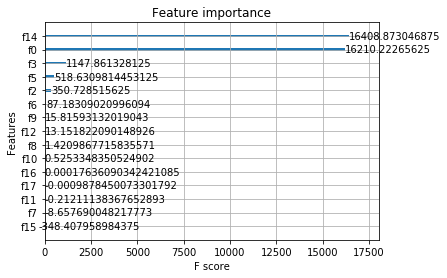

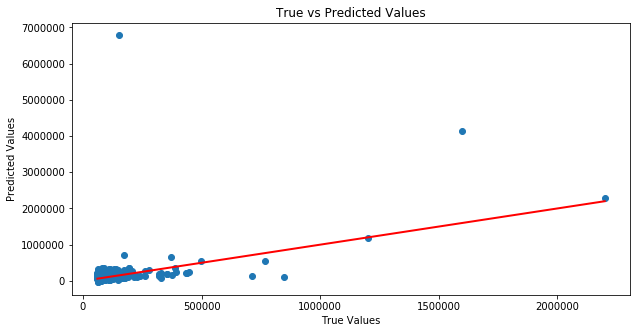

In [23]:
DM_train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical= True)
DM_test = xgb.DMatrix(data=X_test, label=y_test, enable_categorical = True)


# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Define evaluation data
eval_data = [(DM_train, 'train'), (DM_test, 'test')]


# Train the model: xg_gbl
xg_gbl = xgb.train(params=params, dtrain=DM_train, evals =eval_data, num_boost_round=5)


# Predict the labels of the test set: preds
preds = xg_gbl.predict(DM_test)

# Calculate the error RMSE
error = xg_gbl.eval(DM_test)
print('Evaluation Error:', error)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE %f:" % (rmse))
#Measuring Goodness of fit in Training data
from sklearn import metrics
print('Train R2 Value:',metrics.r2_score(y_train, xg_gbl.predict(DM_train)))
#Measuring accuracy on Testing Data
print('Accuracy Test',100- (np.mean(np.abs((y_test - preds) / y_test)) * 100))


# # Plot the feature importance
from matplotlib import pyplot
# plt.figure(figsize=(10, 20))
plot_importance(xg_gbl, max_num_features = 15)
pyplot.show()



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()



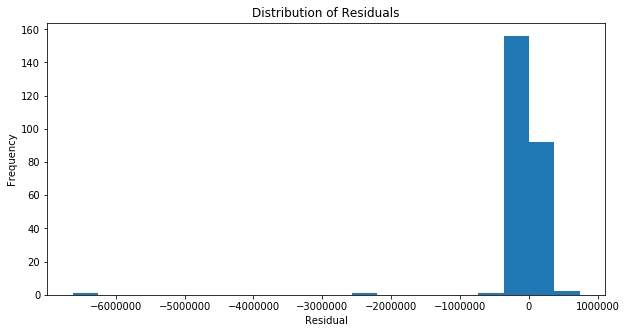

In [24]:
y_test_trans = y_test.reshape(-1)
residuals = y_test_trans - preds
residuals
# preds.shape
# # y_test.shape

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins= 20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()



In [25]:
nil_dmatrix = xgb.DMatrix(data=X, label=y)

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=nil_dmatrix, params=params, nfold=4,
                    num_boost_round=100, metrics='rmse', as_pandas=True, seed=42)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-rmse-mean']).tail(1))



    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0     208724.743084    24861.497921   216320.984616   81897.682167
1     204136.682778    25744.818926   222331.087634   92239.516402
2     201659.202353    26773.264299   223520.643065   96367.778339
3     200554.917342    27274.117626   227285.410976  102058.134734
4     199632.714292    27833.214434   231818.718129  108724.463073
..              ...             ...             ...            ...
95    194921.708857    27038.666062   258114.340701  142411.221202
96    194895.936457    27027.945433   258280.842372  142608.392573
97    194857.854968    27009.759241   258219.931414  142603.837740
98    194831.065831    26998.393968   258248.236463  142582.253807
99    194804.312760    26985.405146   258202.666039  142506.559402

[100 rows x 4 columns]
99    258202.666039
Name: test-rmse-mean, dtype: float64


In [26]:
nil_dmatrix = xgb.DMatrix(data=X, label=y)

# Perform cross-valdiation: cv_results
cv_results = xgb.cv(dtrain=nil_dmatrix, params=params, nfold=4,
                    num_boost_round=100, metrics='mae', as_pandas=True, seed=42)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results['test-mae-mean']).tail(1))



    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0     95450.708242    8748.987502   96174.919771  13173.449896
1     90840.054329    7277.838959   92616.594896  12791.634914
2     89399.000710    7040.478793   92340.055989  13144.848328
3     88678.907809    6933.854251   91901.997864  12889.088595
4     88827.965805    6987.708804   92591.746362  13234.669029
..             ...            ...            ...           ...
95    88600.950881    7401.577919   94811.121425  12753.380787
96    88553.616099    7171.143854   94848.508675  13046.757146
97    88599.081557    7294.726180   94854.536100  13004.616959
98    88508.232215    7262.522839   94759.975005  12887.721386
99    88622.309048    7347.734233   94824.401782  12836.512836

[100 rows x 4 columns]
99    94824.401782
Name: test-mae-mean, dtype: float64


In [27]:
# https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_xgboost_visualisations.ipynb

#initialize dtreevizmodel (adaptor)

# viz_rmodel = dtreeviz.model(model=xg_reg2, tree_index=0, 
#                             X_train=X, 
#                             y_train=y, 
#                             feature_names=Predictors, 
#                             target_name=Target)

**Finetune XGBoost Model- scikit learn**<br> 9 hyperparameters to address bias-variance trade-off:
<br>Iteration Control: num_boost_round; early_stopping_round
<br>Params:
<br> Shrinkage: eta
<br> Tree-Booster constraints: max_depth; min_child_weight; gamma
<br> Random Subsampling: subsample; colsample_bytree
<br> L1 & L2 regularizations: alpha; lambda
<br> Fixed paramaters: objective function for regression ;eval_metric; tree_method (hist; )


**Pre-tuning regression to compare initial performance curves of datasets along training iterations**
<br> Compare training and test performance to assess bias-variance tradeoff(problem of under/over fitting) at initial state
<br> Use for pre/post tuning performance curves comparison to assess regularization impact of tuning. Is tuning effectively performing regularization on model to assess bias-variance tradeoff?

In [28]:
Target = 'NILVAL_LONG_USD'
feature_name = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'EXP_YEARS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN']

X = df_football.drop('NILVAL_LONG_USD', axis=1).values
y =  df_football[['NILVAL_LONG_USD']].values



In [29]:
#params dictionary-baseline parameter to tune
# Define hyperparameters
eval_metrics = []
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0, 
    'reg_alpha': 0.1,
    'reg_lambda': 1,
     'eval_metric': ['rmse', 'mae'],
    # Other parameters-fixed
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'seed' : 42
}
num_boost_round = 1000
early_stopping_rounds = 20   #10

# Define evaluation metrics (metrics)
metrics = {'rmse', 'mae'}

seed = 42

DM_train = xgb.DMatrix(data=X_train, label=y_train, enable_categorical= True)
DM_test = xgb.DMatrix(data=X_test, label=y_test, enable_categorical = True)


def bias_variance_performance(params):
   
    evals_result = {}
    model = xgb.train(
        params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        evals=[(DM_train, "Train"), (DM_test, "Test")],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result,
    
    )
    train_error = evals_result["Train"]["mae"]
    test_error = evals_result["Test"]["mae"]
    train_rmse = evals_result["Train"]["rmse"]
    test_rmse = evals_result["Test"]["rmse"]
    
  
    best_mae = min(evals_result['Test']['mae'])
    best_mae_round = evals_result['Test']['mae'].index(best_mae) + 1  # Add 1 to get the round number
    
    best_rmse = min(evals_result['Test']['rmse'])
    best_rmse_round = evals_result['Test']['rmse'].index(best_rmse) + 1  # Add 1 to get the round number
    
    print("Best MAE before the Tuning: {:.4f} with {} rounds".format(best_mae, best_mae_round))
    print("Best RMSE before the Tuning: {:.4f} with {} rounds".format(best_rmse, best_rmse_round))
    
    return model, evals_result

# num_boost_round = 1000
# early_stopping_rounds = 60
pretuned_model, pre_evals_result = bias_variance_performance(params)

[0]	Train-rmse:230439.59348	Train-mae:113971.32852	Test-rmse:190010.24736	Test-mae:109293.06360
[1]	Train-rmse:186253.70855	Train-mae:83718.35442	Test-rmse:166940.50431	Test-mae:80777.52432
[2]	Train-rmse:154959.73039	Train-mae:63793.85932	Test-rmse:171779.12409	Test-mae:66823.77029
[3]	Train-rmse:132146.81666	Train-mae:51532.01699	Test-rmse:185476.58283	Test-mae:60505.65631
[4]	Train-rmse:114387.83965	Train-mae:44702.86461	Test-rmse:184704.44830	Test-mae:58628.91622
[5]	Train-rmse:101333.84953	Train-mae:41354.20414	Test-rmse:189879.25191	Test-mae:57955.31113
[6]	Train-rmse:91169.47270	Train-mae:38674.05473	Test-rmse:198653.39859	Test-mae:58438.15542
[7]	Train-rmse:82748.44441	Train-mae:36373.02923	Test-rmse:208192.70848	Test-mae:60015.27263
[8]	Train-rmse:75490.43873	Train-mae:34600.05718	Test-rmse:215957.53314	Test-mae:61783.33745
[9]	Train-rmse:70569.78992	Train-mae:33522.30490	Test-rmse:226218.76078	Test-mae:64110.28798
[10]	Train-rmse:66782.77706	Train-mae:32385.06139	Test-rmse:23

Gap for MAE for pre-tuned hyperparametes suggests overfitting
<br>**Plot performance curve for pre-tune MAE and RMSE**

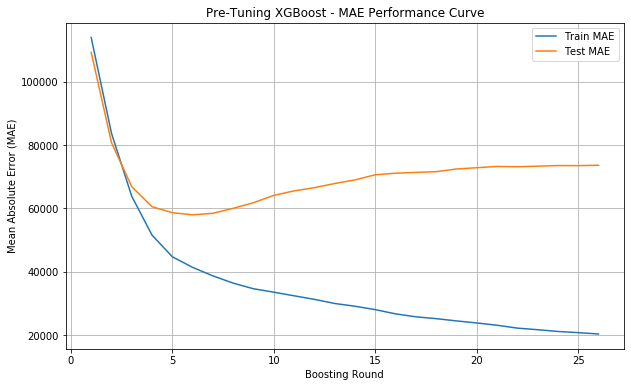

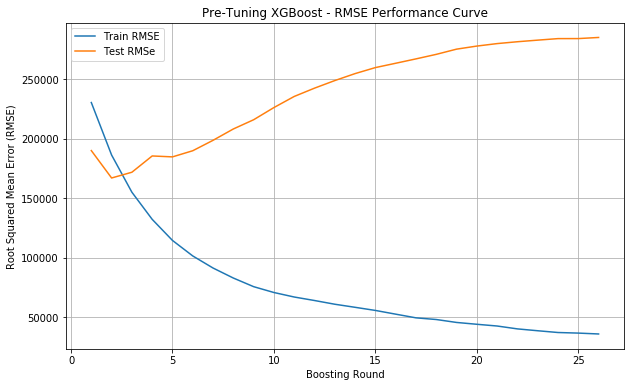

In [30]:
#Extract MAE values for both training and test sets
train_mae = pre_evals_result['Train']['mae']
test_mae = pre_evals_result['Test']['mae']


#Extract RMSE values for both training and test sets
train_rmse = pre_evals_result['Train']['rmse']
test_rmse = pre_evals_result['Test']['rmse']

# Create a plot to visualize the MAE performance curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Train MAE')
plt.plot(range(1, len(test_mae) + 1), test_mae, label='Test MAE')
plt.xlabel('Boosting Round')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Pre-Tuning XGBoost - MAE Performance Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='Train RMSE')
plt.plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSe')
plt.xlabel('Boosting Round')
plt.ylabel('Root Squared Mean Error (RMSE)')
plt.title('Pre-Tuning XGBoost - RMSE Performance Curve')
plt.legend()
plt.grid(True)

As the iterations went on, the initial (pre-tuned) training performance continued improving, while the initial (pre-tuned) test performance stagnated at some point and then started increasing. 
<b> This suggests a salient variance, or over-fitting, in the initial (pre-tuned) model

What is feature importance of model?

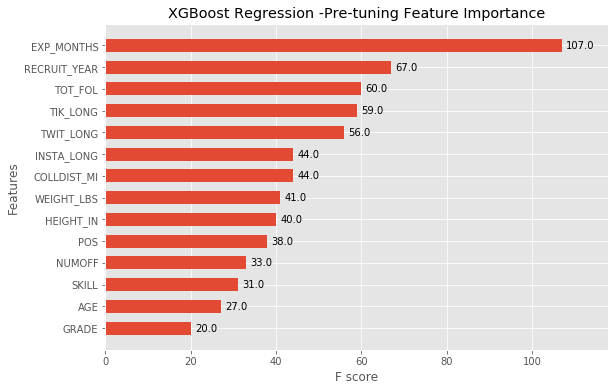

In [31]:


# Obtain the feature importance scores
importance_type = "weight"  # You can use "weight," "gain," or "cover"
importances = pretuned_model.get_score(importance_type=importance_type)

# Sort the features by importance in descending order
sorted_feature_names = sorted(importances, key=importances.get, reverse=True)

# Map sorted_feature_names to the corresponding feature names
mapped_feature_names = [feature_name[sorted_feature_names.index(name)] for name in sorted_feature_names]



mapped_feature_names
# # # Create a feature importance plot with actual feature names as y-axis labels
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(pretuned_model, ax=ax, height=0.6, importance_type=importance_type)
    ax.set_yticklabels(mapped_feature_names)
    ax.set_title('XGBoost Regression -Pre-tuning Feature Importance')


    


**K-Cross Fold Validation**
<br> Use built in xgb.cv() function- performed only on TRAIN set

In [32]:

def perform_k_fold_cross_validation(params, DM_train, metrics, num_boost_round, early_stopping_rounds, num_folds=5):
    """
    Perform k-fold cross-validation for an XGBoost model.

    Parameters:
    - params: XGBoost hyperparameters
    - DM_train: DMatrix for the training data
    - metrics: List of evaluation metrics
    - num_boost_round: Number of boosting rounds
    - early_stopping_rounds: Early stopping criteria
    - num_folds: Number of cross-validation folds (default is 5)

    Returns:
    - cv_results: Cross-validation results as a pandas DataFrame
    """
    cv_results = xgb.cv(
        params=params,
        dtrain=DM_train,
        num_boost_round=num_boost_round,
        seed=42,  # Seed for randomization
        nfold=num_folds,
        metrics=metrics,
        early_stopping_rounds=early_stopping_rounds
    )
    return cv_results

# Call the cross_validation function
cv_results = perform_k_fold_cross_validation(params, DM_train, metrics, num_boost_round, early_stopping_rounds)


In [33]:
cv_results
best_round = cv_results['test-rmse-mean'].idxmin()
best_rmse = cv_results['test-rmse-mean'].min()
best_mae = cv_results['test-mae-mean'][best_round]

print("Best RMSE: {:.4f} at boosting round {}.".format(best_rmse, best_round))
print("Best MAE: {:.4f} at boosting round {}.".format(best_mae, best_round))

Best RMSE: 205128.2387 at boosting round 7.
Best MAE: 66020.0875 at boosting round 7.


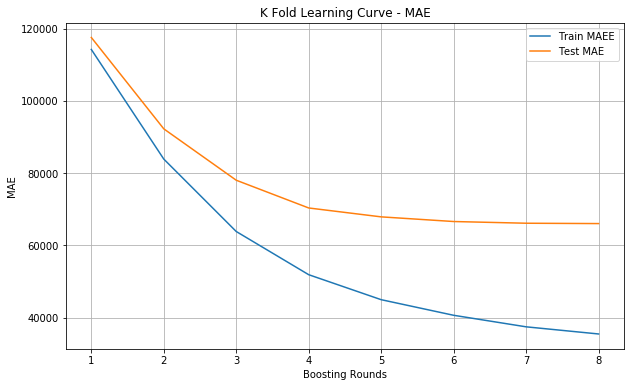

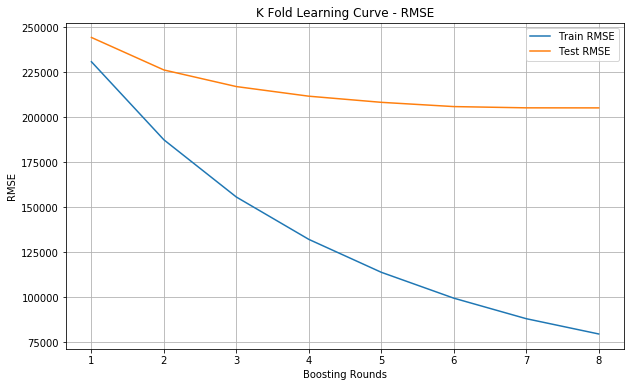

In [34]:

num_boost_rounds = len(cv_results)


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_boost_rounds + 1), cv_results['train-mae-mean'], label='Train MAEE', )
plt.plot(range(1, num_boost_rounds + 1), cv_results['test-mae-mean'], label='Test MAE', )
plt.xlabel('Boosting Rounds')
plt.ylabel('MAE')
plt.title('K Fold Learning Curve - MAE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_boost_rounds + 1), cv_results['train-rmse-mean'], label='Train RMSE', )
plt.plot(range(1, num_boost_rounds + 1), cv_results['test-rmse-mean'], label='Test RMSE', )
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('K Fold Learning Curve - RMSE')
plt.legend()
plt.grid(True)
plt.show()

**Use GridSearchCV to find best parameters**

**GridSearch for all params above takes a long time- try pairwise grid search**

In [35]:
best_score = float('inf')  # Initialize with a high value
best_params = params.copy()  # Initialize with the baseline parameters

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'eta': [0.01, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0.1, 1, 10, 100],
    'eval_metric': ['rmse', 'mae'],
    # Other parameters-fixed
    'objective': ['reg:squarederror'],
    'tree_method': ['hist']
}

# Define sets of hyperparameters to tune as pairs
parameter_sets = [
    ('max_depth', 'eta'),
    ('min_child_weight', 'gamma'),
    ('colsample_bytree', 'subsample'),
    ('reg_alpha', 'reg_lambda')
]

for param_set in parameter_sets:
    param1, param2 = param_set

    for val1 in param_grid[param1]:
        for val2 in param_grid[param2]:
            # Create a copy of the current parameter settings
            params_copy = best_params.copy()

            # Set the values for the current pair of hyperparameters
            params_copy[param1] = val1
            params_copy[param2] = val2

            # Perform grid search using the current hyperparameters
            model, evals_result = bias_variance_performance(params_copy)
            mse = min(evals_result['Test']['mae'])  # Use an appropriate metric

            # Check if this combination of hyperparameters is better
            if mse < best_score:
                best_score = mse
                best_params[param1] = val1
                best_params[param2] = val2

print("Best Hyperparameters:", best_params)
print("Best Score (MAE):", best_score)

[0]	Train-rmse:289921.13938	Train-mae:157011.13192	Test-rmse:251003.34673	Test-mae:151921.63757
[1]	Train-rmse:287980.36405	Train-mae:155484.81251	Test-rmse:248601.53217	Test-mae:150271.21992
[2]	Train-rmse:286059.72240	Train-mae:153973.94867	Test-rmse:246258.88122	Test-mae:148612.56360
[3]	Train-rmse:284159.13761	Train-mae:152477.31685	Test-rmse:243936.15311	Test-mae:146993.40140
[4]	Train-rmse:282278.30378	Train-mae:150995.84751	Test-rmse:241673.34978	Test-mae:145365.99355
[5]	Train-rmse:280417.22166	Train-mae:149528.33089	Test-rmse:239429.50318	Test-mae:143805.33277
[6]	Train-rmse:278568.93310	Train-mae:148078.05046	Test-rmse:237192.99206	Test-mae:142375.60893
[7]	Train-rmse:276745.36922	Train-mae:146639.58693	Test-rmse:235048.35710	Test-mae:140994.76806
[8]	Train-rmse:274934.56141	Train-mae:145217.50743	Test-rmse:232890.89911	Test-mae:139592.74243
[9]	Train-rmse:273142.92525	Train-mae:143809.30199	Test-rmse:230773.77862	Test-mae:138204.36921
[10]	Train-rmse:271374.26708	Train-mae:1

In [36]:

print("Parameters after the Pair Wise Tuning")
best_params

Parameters after the Pair Wise Tuning


{'max_depth': 5,
 'min_child_weight': 4,
 'eta': 0.2,
 'subsample': 0.9,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'reg_alpha': 0.1,
 'reg_lambda': 100,
 'eval_metric': ['rmse', 'mae'],
 'objective': 'reg:squarederror',
 'tree_method': 'hist',
 'seed': 42}

In [37]:
#Now run tuned hyperparmeters (best_params) 
# num_boost_rounds = 1000
# early_stopping_rounds = 94
pw_model_1, pw_evals_result_1 = bias_variance_performance(best_params)

[0]	Train-rmse:277418.70550	Train-mae:130017.66287	Test-rmse:237218.34978	Test-mae:125077.83646
[1]	Train-rmse:266157.41278	Train-mae:109723.99751	Test-rmse:224831.25840	Test-mae:105080.55438
[2]	Train-rmse:257659.46698	Train-mae:94263.21796	Test-rmse:215357.08988	Test-mae:90017.72746
[3]	Train-rmse:250803.88116	Train-mae:83814.59629	Test-rmse:208053.02971	Test-mae:79868.29261
[4]	Train-rmse:245159.23068	Train-mae:77669.08468	Test-rmse:202213.15297	Test-mae:73856.41460
[5]	Train-rmse:241059.67387	Train-mae:74327.31733	Test-rmse:197715.91396	Test-mae:70805.48427
[6]	Train-rmse:237577.63364	Train-mae:72601.86061	Test-rmse:194579.52223	Test-mae:69818.98844
[7]	Train-rmse:233958.78685	Train-mae:70459.19805	Test-rmse:190770.09940	Test-mae:68143.10328
[8]	Train-rmse:230805.63645	Train-mae:68418.30513	Test-rmse:187601.00411	Test-mae:66208.99254
[9]	Train-rmse:228001.41938	Train-mae:66863.03236	Test-rmse:184256.16817	Test-mae:64795.67763
[10]	Train-rmse:225511.37674	Train-mae:65771.18723	Test-

[20]	Train-rmse:207754.78203	Train-mae:59554.15263	Test-rmse:165318.41704	Test-mae:60876.87409
[21]	Train-rmse:206281.50292	Train-mae:59084.81420	Test-rmse:165208.90911	Test-mae:60737.02336
[22]	Train-rmse:205444.61722	Train-mae:58530.84533	Test-rmse:164038.02212	Test-mae:60125.91371
[23]	Train-rmse:204211.58689	Train-mae:58162.24558	Test-rmse:162803.18192	Test-mae:59743.19168
[24]	Train-rmse:203612.05446	Train-mae:57877.69054	Test-rmse:162737.08803	Test-mae:59619.49849
[25]	Train-rmse:202432.20374	Train-mae:57472.81402	Test-rmse:161928.46744	Test-mae:59458.16746
[26]	Train-rmse:201114.57011	Train-mae:57109.60363	Test-rmse:160225.86450	Test-mae:59212.71063
[27]	Train-rmse:199858.34991	Train-mae:56681.93639	Test-rmse:158910.25596	Test-mae:59082.31097
[28]	Train-rmse:198571.24799	Train-mae:56047.64282	Test-rmse:157560.84527	Test-mae:58639.55432
[29]	Train-rmse:197370.47996	Train-mae:55592.98134	Test-rmse:157360.38295	Test-mae:58323.34962
[30]	Train-rmse:196150.01266	Train-mae:55157.86173

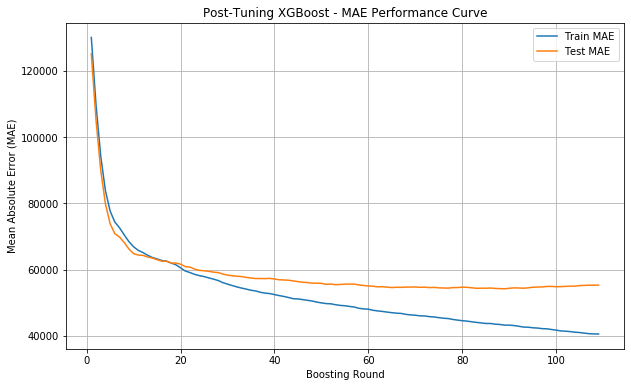

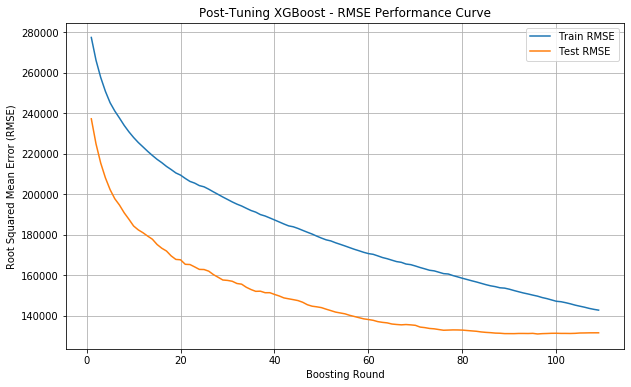

In [38]:
#Extract MAE values for both training and test sets
train_mae = pw_evals_result_1['Train']['mae']
test_mae = pw_evals_result_1['Test']['mae']


#Extract RMSE values for both training and test sets
train_rmse = pw_evals_result_1['Train']['rmse']
test_rmse = pw_evals_result_1['Test']['rmse']

# Create a plot to visualize the MAE performance curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Train MAE' )
plt.plot(range(1, len(test_mae) + 1), test_mae, label='Test MAE' )
plt.xlabel('Boosting Round')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Post-Tuning XGBoost - MAE Performance Curve')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse) + 1), train_rmse, label='Train RMSE' )
plt.plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('Root Squared Mean Error (RMSE)')
plt.title('Post-Tuning XGBoost - RMSE Performance Curve')
plt.legend()
plt.grid(True)

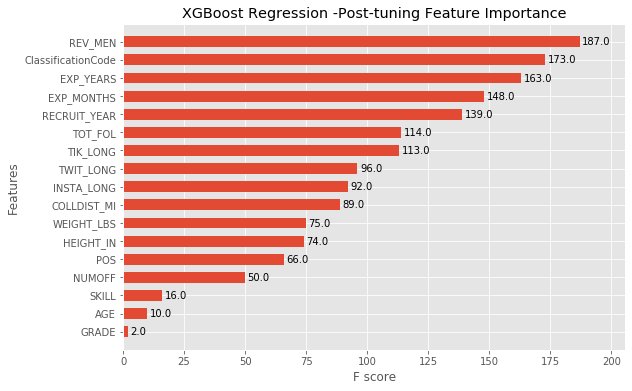

In [39]:


# Obtain the feature importance scores
importance_type = "weight"  # You can use "weight," "gain," or "cover"
importances = pw_model_1.get_score(importance_type=importance_type)

# Sort the features by importance in descending order
sorted_feature_names = sorted(importances, key=importances.get, reverse=True)

# Map sorted_feature_names to the corresponding feature names
mapped_feature_names = [feature_name[sorted_feature_names.index(name)] for name in sorted_feature_names]



mapped_feature_names
# # # Create a feature importance plot with actual feature names as y-axis labels
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(pw_model_1, ax=ax, height=0.6, importance_type=importance_type)
    ax.set_yticklabels(mapped_feature_names)
    ax.set_title('XGBoost Regression -Post-tuning Feature Importance')

#go back and change when early stopping should happend  60???

**Evaluation** During boosting rounds, the model object has learned all the patterns of the training set. Perform testing.

In [40]:
preds1 = pretuned_model.predict(DM_test)
preds2 = pw_model_1.predict (DM_test)


rmse = mean_squared_error(y_test, preds1, squared=False)

rmse2 = mean_squared_error(y_test, preds2, squared=False)

print(f"RMSE of the baseline model: {rmse:.3f}")
print(f"RMSE of the tuned model: {rmse2:.3f}")

mae = mean_absolute_error(y_test, preds1)
mae2 = mean_absolute_error(y_test, preds2)
print(f"MAE of the baseline model: {mae:.3f}")
print(f"MAE of the tuned model: {mae2:.3f}")

# # Calculate the mean of the target variable in the test data
# y_mean = np.mean(y_test)

# # Calculate the total sum of squares (TSS)
# TSS = np.sum((y_test - y_mean)**2)

# # Calculate the residual sum of squares (RSS)
# RSS = np.sum((y_test - preds1)**2)
# RSS2 = np.sum((y_test - preds2)**2)

# # Calculate R-squared (R^2)
# r_squared = 1 - (RSS / TSS)
# r_squared2 = 1 - (RSS2 / TSS)

# print("Baseline R-squared (R^2) =", r_squared)
# print("Tuned R-squared (R^2) =", r_squared2)




RMSE of the baseline model: 285190.559
RMSE of the tuned model: 131468.767
MAE of the baseline model: 73605.556
MAE of the tuned model: 55291.784


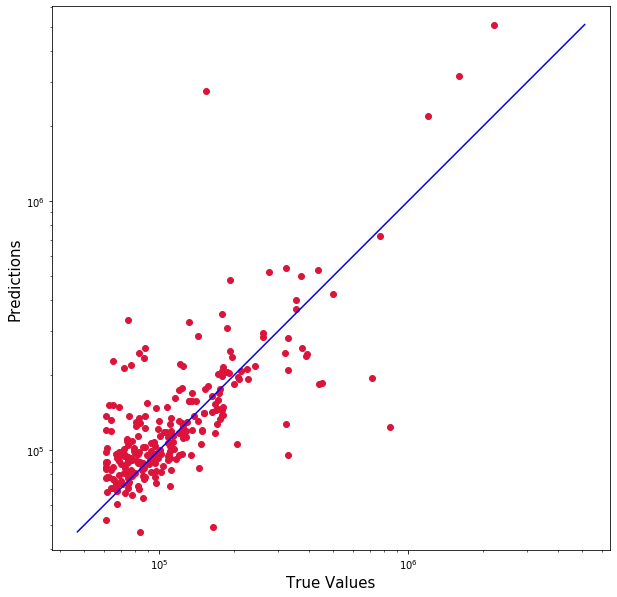

In [41]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, preds1, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(preds1), max(y_test))
p2 = min(min(preds1), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

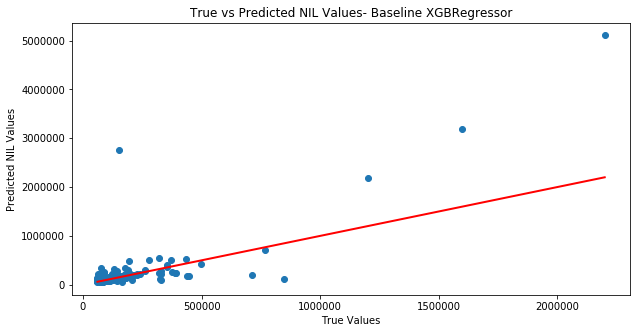

In [42]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted NIL Values')
plt.title('True vs Predicted NIL Values- Baseline XGBRegressor')
plt.show()

In [43]:
# residuals = y_test - preds1

# plt.figure(figsize=(10, 5))
# plt.hist(residuals, bins=20)
# plt.xlabel('Residual')
# plt.ylabel('Frequency')
# plt.title('Distribution of Residuals')
# plt.show()

C:\Users\kakib\AppData\Roaming\Python\Python37\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


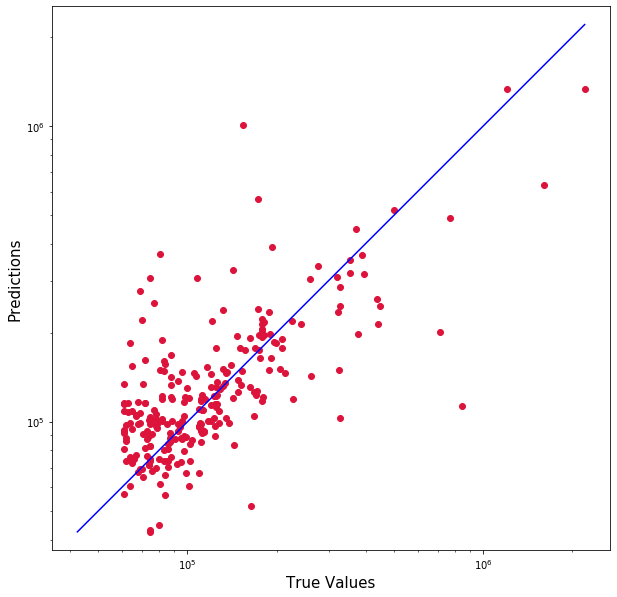

In [44]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, preds2, c='crimson')
plt.yscale('log')
plt.xscale('log')

p11 = max(max(preds2), max(y_test))
p22 = min(min(preds2), min(y_test))
plt.plot([p11, p22], [p11, p22], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

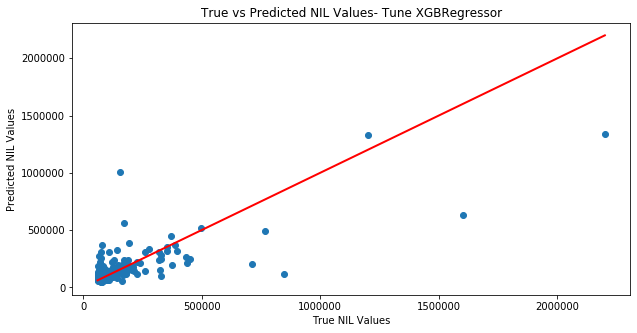

In [45]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, preds2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('True NIL Values')
plt.ylabel('Predicted NIL Values')
plt.title('True vs Predicted NIL Values- Tune XGBRegressor')
plt.show()

In [46]:
# residuals = y_test - preds2

# plt.figure(figsize=(10, 5))
# plt.hist(residuals, bins=20)
# plt.xlabel('Residual')
# plt.ylabel('Frequency')
# plt.title('Distribution of Residuals')
# plt.show()